In [1]:
import torch
from torch.autograd import Variable
from model import UNet, DiscConvNet
import matplotlib.pyplot as plt
import os
import numpy as np
from dataBatcher import *
os.environ['CUDA_VISIBLE_DEVICES']='0'

### Defining global variables

In [2]:
input_file_names, target_file_names = readFileNames()
input_file_names_train = input_file_names[0:2000] # 2000 files used for training
target_file_names_train = target_file_names[0:2000]
input_file_names_test = input_file_names[2000:] # remaining 520 files used for validation
target_file_names_test = target_file_names[2000:]
train_size = len(input_file_names_train)
test_size = len(input_file_names_test)
dtype = torch.cuda.FloatTensor
image_shape = [116, 132, 132]
print(train_size, test_size)

2000 520


### Model forward (not necessary to run)

In [ ]:
input_file = '/mnt/sdb1/intern_data/pix2pix_wbce_pet3d/train/1_input.npy'
input_arr = np.load(input_file).reshape(1,1,116,132,132)
input_arr = Variable(torch.from_numpy(input_arr).float().cuda(), volatile = False) # set volatile to false for training
model = UNet(n_ch = 1, n_class = 1).cuda()
pred_arr = model(input_arr)
pred_arr = pred_arr.data.cpu().numpy()
pred_arr = pred_arr.reshape(28,44,44)
print(pred_arr.shape)

### Get corresponding ground truths (not necessary to run)

In [ ]:
target_file = '/mnt/sdb1/intern_data/pix2pix_wbce_pet3d/train/1_target.npy'
target_arr = np.load(target_file)
shape = target_arr.shape
print('Raw target shape : ', target_arr.shape)
target_arr = target_arr[shape[0]//2-14:shape[0]//2+14, shape[1]//2-22:shape[1]//2+22, shape[2]//2-22:shape[2]//2+22]
print('Cropped target shape : ', target_arr.shape) # this is the image to train the model with

### Noise (to be sent to the generator)

In [3]:
def sample_noise(batch_size, channels = 1, width = 116, height = 132, depth = 132):
    z = torch.rand(batch_size, channels, width, height, depth)
    return z

### Defining Loss

In [4]:
def bce_loss(scores, target):
    neg_abs = -scores.abs()
    loss = scores.clamp(min=0) - scores * target + (1 + neg_abs.exp()).log() # numerically stable implementation of binary cross entropy loss
    return loss.mean()

In [5]:
def generator_loss(fake_logits, gentd_output, desired_output, lmbd = 20):
    l1 = bce_loss(fake_logits, 1)
    n = gentd_output.shape[0]
    l2 = ((gentd_output - desired_output) ** 2.0).sum() / n # l2 loss between generated and desired image
    loss = l1 + (lmbd * l2) # combining losses
    return loss

In [6]:
def discriminator_loss(real_logits, fake_logits):
    loss = bce_loss(real_logits, 1) + bce_loss(fake_logits, 0)
    return loss

### Defining Optimizer

In [7]:
def get_optimizer(model):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.00001, betas=(0.5, 0.999))
    return optimizer

### Defining train function

In [8]:
def train(Discriminator, Generator, D_Opti, G_Opti, print_every=100, batch_size=1, num_epochs=10):
    i = 0
    gen_losses = [] # making a list of the computed losses to be plotted later
    disc_losses = []
    best_val_loss = 999999
    for epoch in range(num_epochs):
        disc_iter = batchIterator(input_file_names_train, target_file_names_train, batch_size)
        gen_iter = batchIterator(input_file_names_train, target_file_names_train, batch_size)
        for _ in range(train_size // batch_size):
            input, target = next(disc_iter)
            D_Opti.zero_grad()
            input_data = Variable(torch.from_numpy(input).float().cuda(), volatile = False)
            target_data = Variable(torch.from_numpy(target).float().cuda(), volatile = False)
            logits_real = Discriminator(target_data)
            g_noise = Variable(sample_noise(batch_size).float().cuda(), volatile = False)
            input_data = torch.cat((input_data, g_noise), 1) # combining data with noise for the generator
            fake_images = Generator(input_data).detach().view(batch_size, 1, 28, 44, 44)
            logits_fake = Discriminator(fake_images)
            DiscLoss = discriminator_loss(logits_real, logits_fake)
            DiscLoss.backward()
            D_Opti.step()
            disc_losses.append(DiscLoss.data[0])
            # different data for generator and discriminator
            gen_input, gen_target = next(gen_iter)
            G_Opti.zero_grad()
            gen_input_data = Variable(torch.from_numpy(gen_input).float().cuda(), volatile = False)
            gen_target_data = Variable(torch.from_numpy(gen_target).float().cuda(), volatile = False)
            gen_noise = Variable(sample_noise(batch_size).float().cuda(), volatile = False)
            gen_input_data = torch.cat((gen_input_data, gen_noise), 1)
            fake_gen_images = Generator(gen_input_data).view(batch_size, 1, 28, 44, 44)
            gen_logits_fake = Discriminator(fake_gen_images)
            GenLoss = generator_loss(gen_logits_fake, fake_gen_images, gen_target_data)
            GenLoss.backward()
            G_Opti.step()
            gen_losses.append(GenLoss.data[0])
            if(i % print_every == 0):
                print("Iteration number = %d, Discriminator Loss = %f" % (i, DiscLoss))
                print("Iteration number = %d, Generator Loss = %f" % (i, GenLoss))
            i+= 1
        # validation for best epoch
        if (epoch%2 == 0):
            val_iter = batchIterator(input_file_names_test, target_file_names_test, batch_size)
            val_loss = 0
            for _ in range(test_size // batch_size):
                test_input, test_target = next(val_iter)
                test_input = Variable(torch.from_numpy(test_input).float().cuda(), volatile = True)
                test_target = Variable(torch.from_numpy(test_target).float().cuda(), volatile = True)
                gen_noise_test = Variable(sample_noise(batch_size).float().cuda(), volatile = True)
                gen_input_data_test = torch.cat((test_input, gen_noise_test), 1)
                fake_gen_images_test = Generator(gen_input_data_test).view(batch_size, 1, 28, 44, 44)
                gen_logits_fake_test = Discriminator(fake_gen_images_test)
                GenLoss_test = generator_loss(gen_logits_fake_test, fake_gen_images_test, test_target)
                val_loss += GenLoss_test.data[0]
            val_loss = val_loss / (test_size // batch_size)
            print("Epoch = ", epoch, "val_loss = ", val_loss)
            if (val_loss < best_val_loss):
                best_val_loss = val_loss
                torch.save(Generator.state_dict(), 'models/best_generator.pt')
                torch.save(Discriminator.state_dict(), 'models/best_discriminator.pt')
        
        torch.save(Generator.state_dict(), 'models/generator_bce_epoch'+str(epoch+1)+'.pt')
        torch.save(Discriminator.state_dict(), 'models/discriminator_bce_epoch'+str(epoch+1)+'.pt')
    plt.figure()
    plt.plot(gen_losses)
    plt.figure()
    plt.plot(disc_losses)
    plt.show()

### Training the network

Iteration number = 0, Discriminator Loss = 1.323563
Iteration number = 0, Generator Loss = 82624.898438
Iteration number = 100, Discriminator Loss = 1.316953
Iteration number = 100, Generator Loss = 15872.484375
Iteration number = 200, Discriminator Loss = 1.165173
Iteration number = 200, Generator Loss = 6273.446777
Iteration number = 300, Discriminator Loss = 1.522403
Iteration number = 300, Generator Loss = 7133.627441
Iteration number = 400, Discriminator Loss = 1.285836
Iteration number = 400, Generator Loss = 33684.703125
Iteration number = 500, Discriminator Loss = 1.086105
Iteration number = 500, Generator Loss = 9425.375977
Iteration number = 600, Discriminator Loss = 1.152814
Iteration number = 600, Generator Loss = 7410.121582
Iteration number = 700, Discriminator Loss = 0.995198
Iteration number = 700, Generator Loss = 5535.256348
Iteration number = 800, Discriminator Loss = 1.062833
Iteration number = 800, Generator Loss = 5293.995117
Iteration number = 900, Discriminator 

Iteration number = 7500, Discriminator Loss = 0.248884
Iteration number = 7500, Generator Loss = 653.308594
Iteration number = 7600, Discriminator Loss = 0.062008
Iteration number = 7600, Generator Loss = 36655.527344
Iteration number = 7700, Discriminator Loss = 0.158150
Iteration number = 7700, Generator Loss = 3582.761963
Iteration number = 7800, Discriminator Loss = 0.324748
Iteration number = 7800, Generator Loss = 356.391296
Iteration number = 7900, Discriminator Loss = 0.129256
Iteration number = 7900, Generator Loss = 386.275238
Iteration number = 8000, Discriminator Loss = 0.312315
Iteration number = 8000, Generator Loss = 307.162262
Iteration number = 8100, Discriminator Loss = 0.043343
Iteration number = 8100, Generator Loss = 4976.629395
Iteration number = 8200, Discriminator Loss = 0.288845
Iteration number = 8200, Generator Loss = 686.850098
Iteration number = 8300, Discriminator Loss = 0.068151
Iteration number = 8300, Generator Loss = 195.185242
Iteration number = 8400,

Iteration number = 14900, Discriminator Loss = 0.022803
Iteration number = 14900, Generator Loss = 154631.046875
Iteration number = 15000, Discriminator Loss = 0.019675
Iteration number = 15000, Generator Loss = 272.692169
Iteration number = 15100, Discriminator Loss = 0.013946
Iteration number = 15100, Generator Loss = 9583.496094
Iteration number = 15200, Discriminator Loss = 0.012430
Iteration number = 15200, Generator Loss = 103.536606
Iteration number = 15300, Discriminator Loss = 0.013218
Iteration number = 15300, Generator Loss = 636.075317
Iteration number = 15400, Discriminator Loss = 0.013339
Iteration number = 15400, Generator Loss = 93.644516
Iteration number = 15500, Discriminator Loss = 0.014082
Iteration number = 15500, Generator Loss = 81.049255
Iteration number = 15600, Discriminator Loss = 0.012461
Iteration number = 15600, Generator Loss = 7244.620117
Iteration number = 15700, Discriminator Loss = 0.018025
Iteration number = 15700, Generator Loss = 237.912155
Iterati

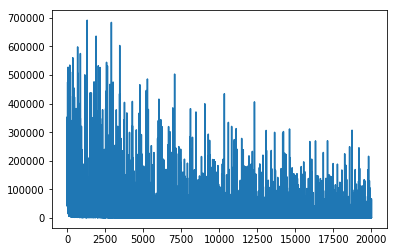

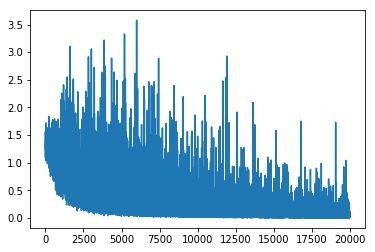

In [9]:
Discriminator = DiscConvNet(image_shape).type(dtype)
Generator = UNet(n_ch = 2, n_class = 1).type(dtype)
D_Opti = get_optimizer(Discriminator)
G_Opti = get_optimizer(Generator)
train(Discriminator, Generator, D_Opti, G_Opti)